In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/data.zip

## SenNetworks: Hacking the Human Vasculature in 3D

#### Authors: Andrew Kettle and Hitarth Ghandi


In [3]:
# Packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.io
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import os
import shutil
# import transformers # Hugging Face for Segformer models

from sklearn.model_selection import train_test_split
# from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

### Dataset

In the following two cells, we wrote code to handle the dataset ingestion. This particular dataset has overlapping names that need to be addressed.


In [24]:
# Dataset to be used by pytorch loaders
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type):
		self.run_type = run_type
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths

	def importTifAndResize(self, path):
		image = cv2.imread(path) # Read
		image = cv2.resize(image, (512, 512))	  # Resize
		image = np.moveaxis(image, -1, 0)		  # Reorder to CWH
		return image

	def importTifAndResizeAndGray(self, path):
		image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Read
		image = cv2.resize(image, (512, 512))	  # Resize
		return image

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		if self.run_type != 'test':
			image = self.importTifAndResize(self.image_paths[idx])
			label = self.importTifAndResizeAndGray(self.label_paths[idx])
			return image, label
		else:
			# Label is copied depth wise, only take one channel
			image = self.importTifAndResize(self.image_paths[idx])
			return image, ''

# Rename items in the dataset so there is no overlap (only run this once!)
def renameDataset():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	# Iterate over each subset
	for p in paths:

		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		if(p.count('DS_Store')):
			continue
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)

		# Name to append for each file (splitting is platform specific)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]

		# Rename images
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		# Rename labels
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

# Write function for populating numpy arrays associated with the data
def buildDataset(root_dir: str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	# Logic for training or testing
	if run_type == 'train':
		working_dir = os.path.join(root_dir, "train")
	elif run_type == 'test':
		working_dir = os.path.join(root_dir, "test")
	else:
		print("Unsupported run_type in the buildDataset function")
		assert(False) # Quick hack to exit execution

	paths = os.listdir(working_dir)
	paths = [os.path.join(working_dir, p) for p in paths]

	for p in paths:

		image_path = os.path.join(p, "images")
		if(p.count('DS_Store')):
			continue
		image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
		image_paths.append(np.array(image_names))

		if run_type == 'train':
			label_path = os.path.join(p, "labels")
			label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
			label_paths.append(np.array(label_names))

	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [ ]:
# cd content

In [20]:
# ls

In [21]:
# Uncomment this on first run to format the dataset properly
# renameDataset()

In [26]:
# Ingest data, store in numpy arrays (done here so that we can split)
Xtr, Ytr = buildDataset(os.path.join(os.getcwd(), 'data'), 'train')
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

# Xte, _ = buildDataset(os.path.join(os.getcwd(), 'data'), 'test')
# print(f"Xte.shape: {Xte.shape}")

Xtr.shape: (2279,) Ytr.shape: (2279,)


#### Cleaning

Observe that the training set has fewer labels than images. Since we are data rich, we will elect to toss out the samples that don't have labels for the sake of simplicity.


In [27]:
# Trim file extensions
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

# Find overlap
c = np.where(np.intersect1d(a, b))

# Drop extra items from training set
Xtr = Xtr[c]
Ytr = Ytr[c]

Split data into training and testing using 80/20 split


In [28]:
# Split dataset into training and validation
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

Xtr: (1823,), Ytr: (1823,)
Xval: (456,), Yval: (456,)


#### Create dataset and dataloader


In [30]:
# Create datasets and set paths
trds = SenDataset('train')
### TEMPORARY FOR EVALUATING TRAINING REGIME ###
trds.setPaths(Xtr[10:], Ytr[10:])
#trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation')
valds.setPaths(Xval[2:], Yval[2:])

# teds = SenDataset('test')
# teds.setImagePath(Xte)

batch_size = 16

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(teds, batch_size=batch_size)

(3, 512, 512)
(512, 512)


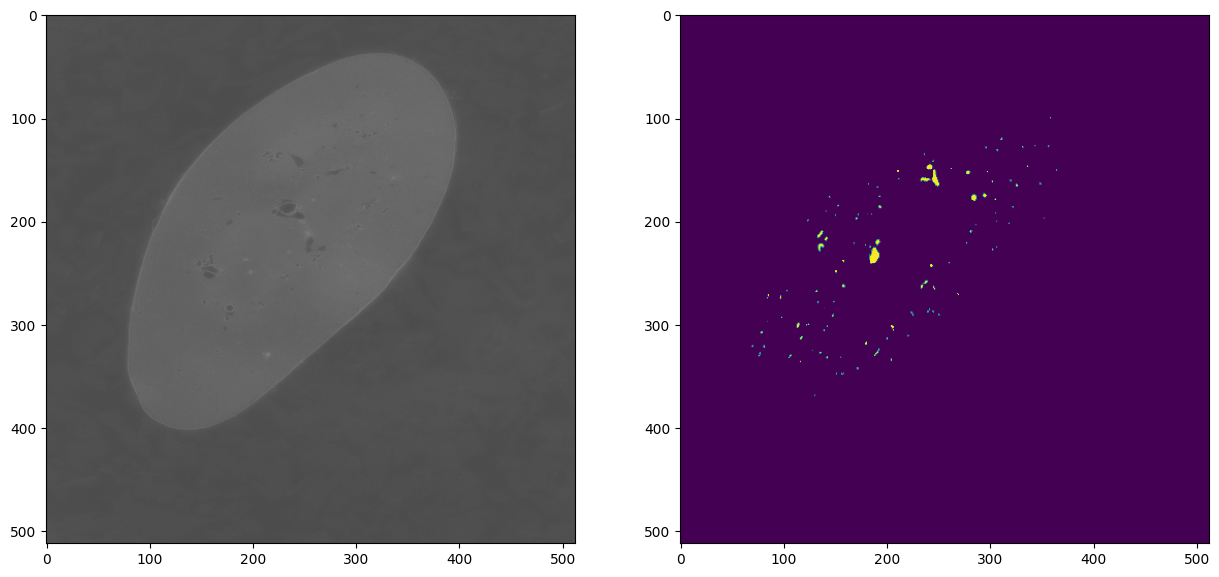

In [31]:
# Show example of image label

image, label = trds.__getitem__(3)

print(image.shape)
print(label.shape)

# Reshape for display
image = np.moveaxis(image, 0, -1)
label = np.moveaxis(label, 0, -1)

# Display image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image)
ax[1].imshow(label)
plt.show()

## Implement Segformer on the Vascular Dataset


### Loss Function Implementations for training


In [32]:
# Pytorch Dice Loss Implmentations from: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

#PyTorch
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

#PyTorch
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [ ]:
# Handles feature extraction and transformations
# In default form, resizes,
#seg_ip = transformers.SegformerImageProcessor.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')

#config = transformers.SegformerConfig(num_labels=1) # 1 label = binary classification
#model = transformers.SegformerForSemanticSegmentation(config)

model = transformers.SegformerForSemanticSegmentation.from_pretrained('nvidia/mit-b0', num_labels=1)

In [ ]:
# Put model on GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
model = model.to(device) # Send model to device before creating optimizer

# Optimizer
optimizer = torch.optim.Adam(model.parameters()) # Use default rate 1e-3
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1./4., end_factor=1.)

In [ ]:
# Training Loop
total_steps = len(train_loader)
epochs = 10

train_loss_avg = []
val_loss_avg = []


# Train network
for ep in range(epochs):
	per_epoch_loss_train = []
	per_epoch_loss_val = []

	for idx, (images, masks) in enumerate(train_loader):
		# Convert vars to GPU
		images = images.float().to(device)
		masks = masks.float().to(device)

		# Normalize to range [0, 1]
		masks = masks / 255.

		output = model(pixel_values=images, labels=masks)
		loss = output.loss
		loss.backward()

		optimizer.step()
		#lr_scheduler.step()
		optimizer.zero_grad()

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

KeyboardInterrupt: 

In [ ]:
# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

## Use Segment-Anything (SAM) to Attempt Zero-Shot Segmentation


In [ ]:
# Import SAM model

checkpoint = os.path.join(os.path.join(os.getcwd(), 'model'), 'sam_vit_h_4b8939.pth')

device = 'cuda:0' if torch.cuda.is_available else 'cpu'

sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

In [73]:
# Grab a few random images from the training set
idxs = np.random.choice(np.arange(Xtr.shape[0]), 3)

images = [trds.__getitem__(x)[0] for x in idxs]
labels = [trds.__getitem__(x)[1] for x in idxs]

# Make prediction
totalmasks = []

for image in images:
	masks = mask_generator.generate(image)
	totalmasks.append(np.array(masks))

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

In [ ]:
# From segment-anything automatic_mask_generator_example.ipynb in the FAIR Github repository
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))

    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    return img

# Show examples
fig, ax = plt.subplots(3, 3, figsize = (12, 12))
fig.tight_layout() # Make plot look better

ax[0,0].set_title('Images')
ax[0,1].set_title('Predictions')
ax[0,2].set_title('Labels')

# Images
ax[0,0].imshow(images[0])
ax[1,0].imshow(images[1])
ax[2,0].imshow(images[2])

# Predictions
ax[0,1].imshow(show_anns(totalmasks[0]))
ax[0,1].set_autoscale_on(False)
ax[1,1].imshow(show_anns(totalmasks[1]))
ax[1,1].set_autoscale_on(False)
ax[2,1].imshow(show_anns(totalmasks[2]))
ax[2,1].set_autoscale_on(False)

# Labels
ax[0,2].imshow(labels[0])
ax[1,2].imshow(labels[1])
ax[2,2].imshow(labels[2])

plt.show()


### Zero-shot SAM Performance

Straight out of the box, SAM performs poorly for our vascular dataset challenge. Looking at the middle column, it is evident that some segmentation is taking place, but it isn't relevant to the vascular problem. The list of issues is summarized below.

1. SAM is performing instance segmentation, but we have a binary segmentation problem
2. The structure of biological images differs heavily from "natural images". Examples: No color features (images are grayscale upscaled to RGB), lower Signal to Noise Ratio (qualitative)
3. SAM does not have knowledge of the vascular problem we are trying to solve.
4. SAM needs to be prompted (bounding box, text, etc) which isn't included in our dataset. We could potentially augment bounding boxes, but the dataset doesn't seem that well suited to rectangular boxes.

Conclusion:  
SAM is not a suitable solution for this problem with this dataset.


### What part of SAM do we have control over?


# UNET


In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [35]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally

In [36]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [37]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        # print(data.shape)
        data = data.float().to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [38]:
scalar = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scalar)

100%|██████████| 114/114 [05:38<00:00,  2.97s/it, loss=-69.2]


In [39]:
# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

In [88]:
def test_fn(loader, model, device):
    model.eval()
    final_predictions = []
    targets = []
    loop = tqdm(loader)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loop):
            data = data.float().to(device=device)
            target = target.float().to(device=device)

            # predictions = torch.sigmoid(model(data))
            predictions = model(data)
            predictions = predictions.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            final_predictions.append(predictions)
            targets.append(target)
    final_predictions = np.vstack(final_predictions)
    targets = np.vstack(targets)
    return np.array(final_predictions), np.array(targets)

In [89]:
y_val_pred, y_val_target = test_fn(valid_loader, model, DEVICE)

100%|██████████| 29/29 [00:37<00:00,  1.29s/it]


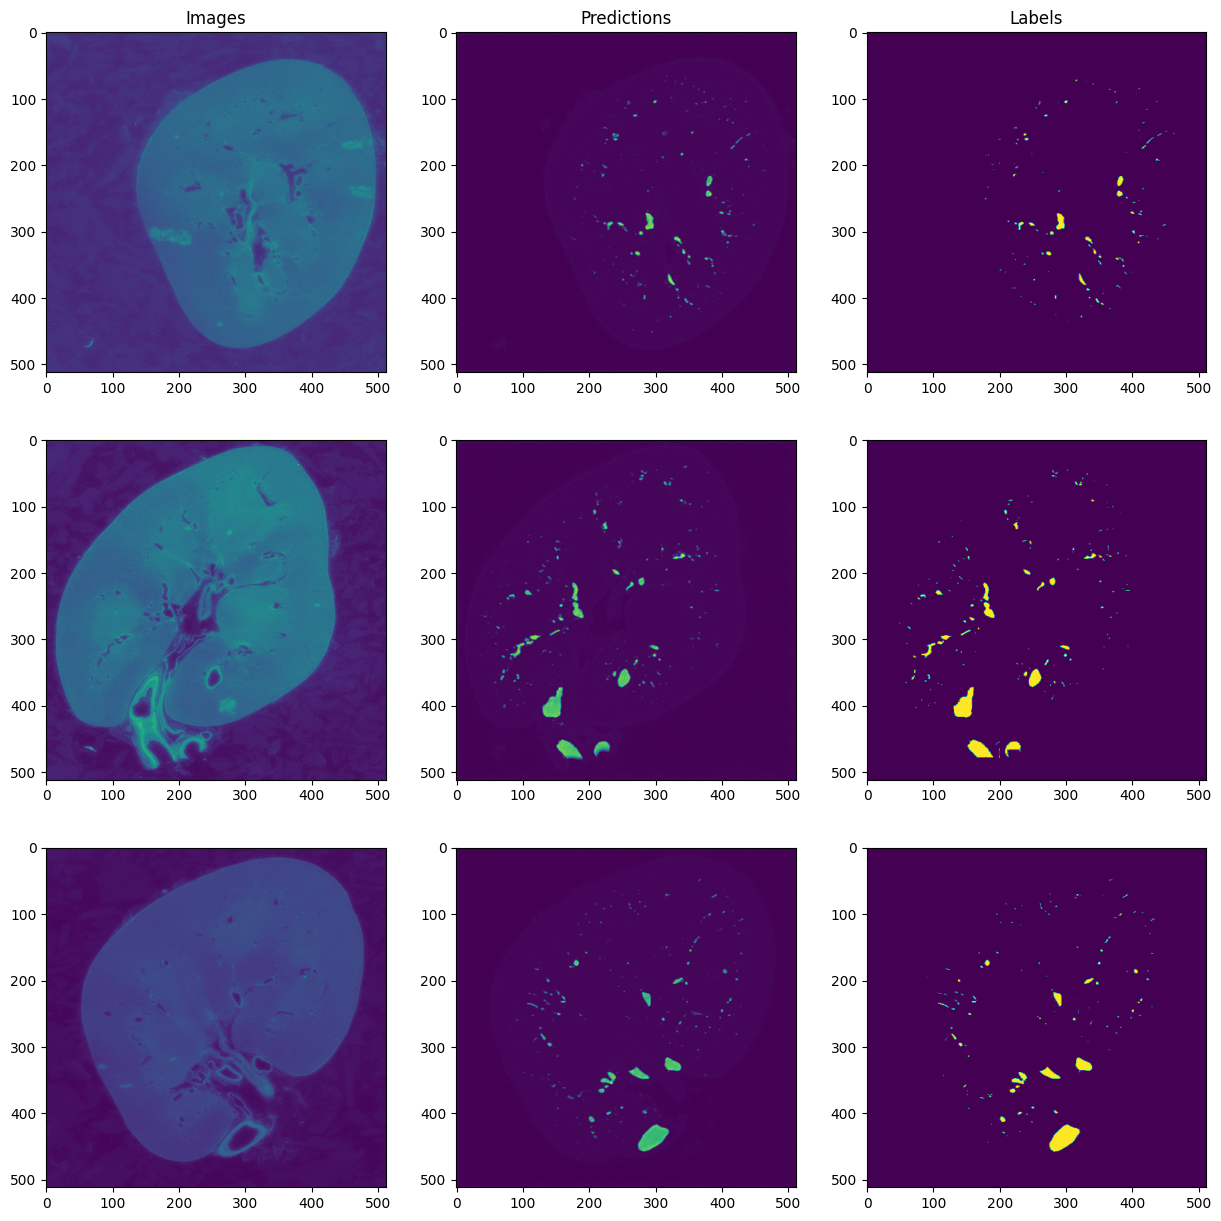

In [95]:
n_samples = 3
fig, ax = plt.subplots(3, n_samples, figsize=(15, 15))
for i in range(n_samples):
    ax[i, 0].imshow(valds.__getitem__(i)[0][0])
    ax[i, 1].imshow(np.squeeze(y_val_pred[i]))
    ax[i, 2].imshow(np.squeeze(y_val_target[i]))
ax[0,0].set_title('Images')
ax[0,1].set_title('Predictions')
ax[0,2].set_title('Labels')
plt.show()